In [1]:
from keras import backend as K
#from keras.regularizers import l2, activity_l2
from keras import backend as K
from keras.engine.topology import Layer
from keras.optimizers import RMSprop, SGD, Adam
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Bidirectional, merge
from keras.layers.convolutional import Convolution1D, AtrousConvolution1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras.layers import Conv1D
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
def get_data():
    xtrain = pd.read_csv("train/0_train.csv", header=None)
    xtrain = xtrain.get_values()
    xtrain = xtrain[np.newaxis,:,:]
    
    for i in range(1,200):
        if i % 20 == 0:
            print(i)
        buf = pd.read_csv("train/" + str(i) + "_train.csv", header=None)
        buf = buf.get_values()
        buf = buf[np.newaxis,:,:]
        xtrain = np.append(xtrain, buf, axis=0)
    return xtrain

In [5]:
ytrain = pd.read_csv("train/train_labels.csv")
ytrain = ytrain["Attack"]

In [6]:
xtrain = get_data()

20
40
60
80
100
120
140
160
180


# Модель 1

In [90]:
del model


In [104]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

model = Sequential()

model.add(Conv1D(32, 5, activation='tanh', input_shape=(96000, 56)))

#model.add(MaxPooling1D(3))
#model.add(Conv1D(64, 3, activation='tanh'))
#model.add(Conv1D(64, 3, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
    optimizer='rmsprop')

#score = model.evaluate(x_test, y_test, batch_size=16)

In [105]:
checkpointer = ModelCheckpoint(filepath="weights.{epoch:02d}.hdf5", verbose=1, save_best_only=False)
model.fit(xtrain[:150,:96000,:], ytrain[:150], batch_size=50, epochs=15, validation_split=0.2, callbacks=[checkpointer])

Train on 120 samples, validate on 30 samples
Epoch 1/15
100/120 [========================>.....] - ETA: 73s - loss: 8.6089 

KeyboardInterrupt: 

In [92]:
model.load_weights("weights.10.hdf5")

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
pred = model.predict_proba(xtrain[150:200, :96000, :])

50/50 [==============================] - 3s     


In [94]:
pred

array([[ 0.39875457],
       [ 0.43735555],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.44399229],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.39875457],
       [ 0.43735555],
       [ 0.43735555],
       [ 0

In [95]:
(uu, tt, rr) = roc_curve(ytrain[150:200], pred)


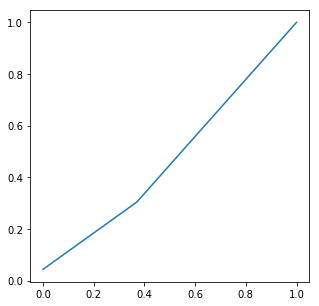

In [96]:
plt.figure(figsize=[5,5])
plt.plot(uu, tt)

# Модель 2

In [178]:
model = Sequential()
model.add(Embedding(1000, output_dim=256))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [179]:
checkpointer = ModelCheckpoint(filepath="mod2/weights.{epoch:02d}.hdf5", verbose=1, save_best_only=False)
model.fit(xtrain[:150,:96000,:], ytrain[:150], batch_size=50, epochs=15, validation_split=0.2, callbacks=[checkpointer])

ValueError: Error when checking model input: expected embedding_2_input to have 2 dimensions, but got array with shape (150, 96000, 56)

# Модель 3

In [125]:
#Предсказане временного ряда

In [157]:
def generator(data):
    n_prev=1000
    for i in range(len(data)-n_prev):
        yield (np.array(data.iloc[i:i+n_prev].as_matrix()), np.array(data.iloc[i+n_prev].as_matrix()))


In [167]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_out_neurons = 56  
hidden_neurons = 100

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(200, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [143]:
import numpy as np

def _load_data(data, n_prev = 200):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

In [168]:
train = pd.DataFrame(xtrain[0])
#(X_train, y_train), (X_test, y_test) = train_test_split(train)  # retrieve data


In [169]:
model.fit_generator(generator(train), epochs=10, steps_per_epoch=1)


Epoch 1/10


ValueError: Error when checking model input: expected lstm_9_input to have 3 dimensions, but got array with shape (1000, 56)

In [171]:
for i in generator(train):
    print(i)
    break

(array([[  2.40000000e+01,   2.66300000e-01,   3.63316630e+03, ...,
          1.00000000e+02,   1.25809000e+01,   1.11810800e+02],
       [  2.40010000e+01,   2.68200000e-01,   3.66047580e+03, ...,
          1.00000000e+02,   1.24640000e+01,   1.11906900e+02],
       [  2.40020000e+01,   2.65400000e-01,   3.65622140e+03, ...,
          1.00000000e+02,   1.25461000e+01,   1.10433000e+02],
       ..., 
       [  2.49970000e+01,   2.64700000e-01,   3.67782140e+03, ...,
          1.00000000e+02,   1.21378000e+01,   1.14782800e+02],
       [  2.49980000e+01,   2.64900000e-01,   3.64404040e+03, ...,
          1.00000000e+02,   1.21870000e+01,   1.14641200e+02],
       [  2.49990000e+01,   2.66800000e-01,   3.65518710e+03, ...,
          1.00000000e+02,   1.21963000e+01,   1.15182300e+02]]), array([  2.50000000e+01,   2.66800000e-01,   3.66460180e+03,
         4.42405580e+03,   9.18580000e+00,   3.23796000e+01,
         4.67388000e+01,   2.79842330e+03,   6.48248000e+01,
         1.22901600e+

In [97]:
roc_auc_score(ytrain[150:200], pred)

0.47504025764895336

In [ ]:
0.64412238325281801

/home/fao3864/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


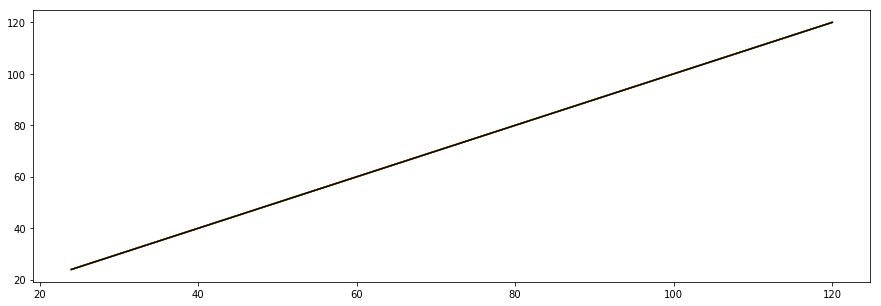

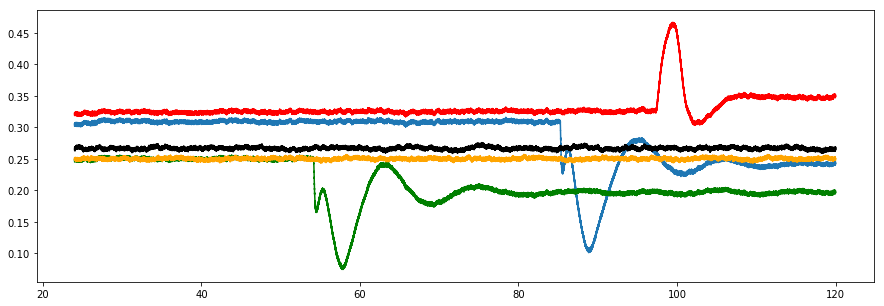

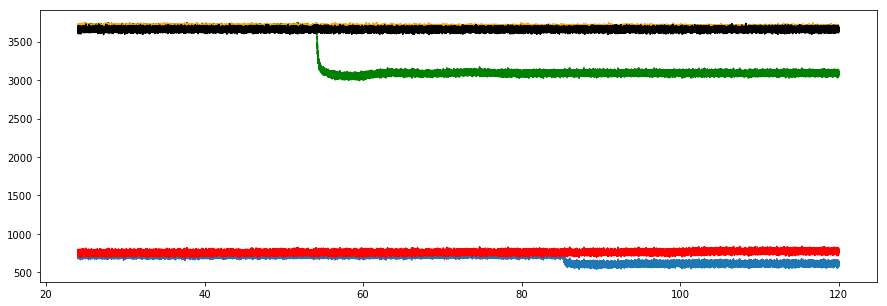

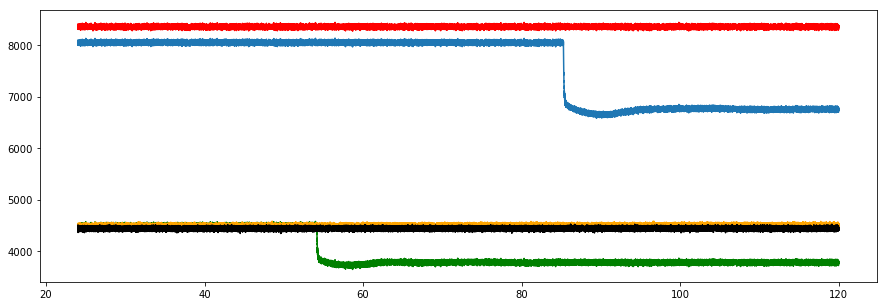

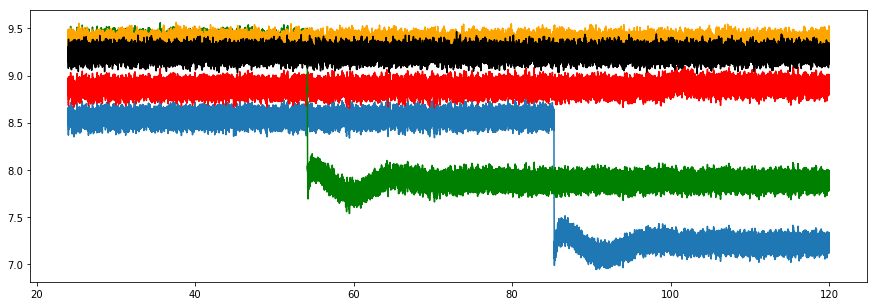

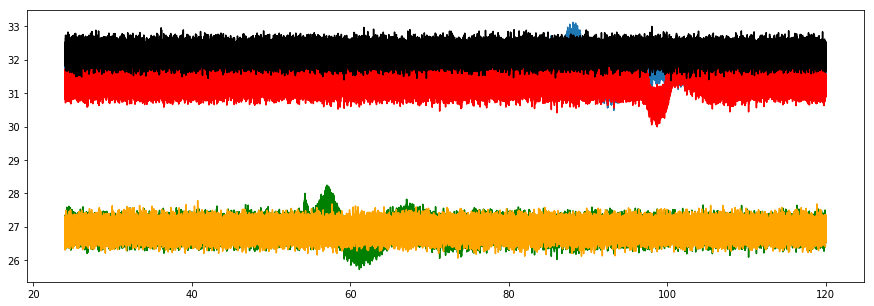

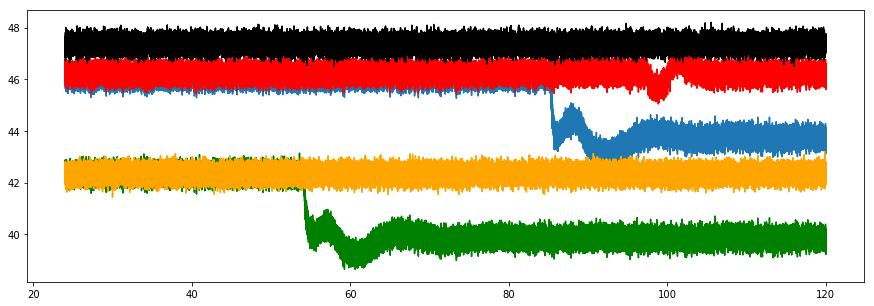

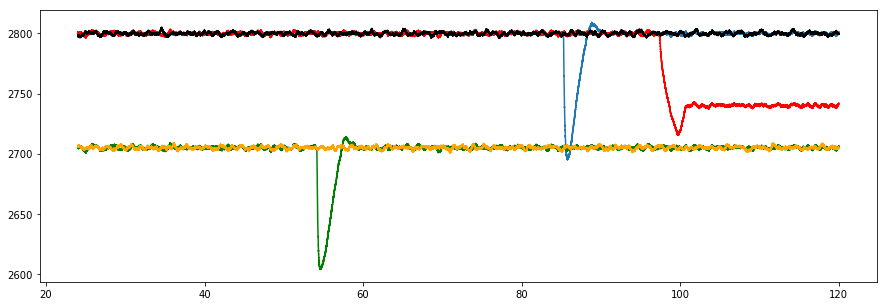

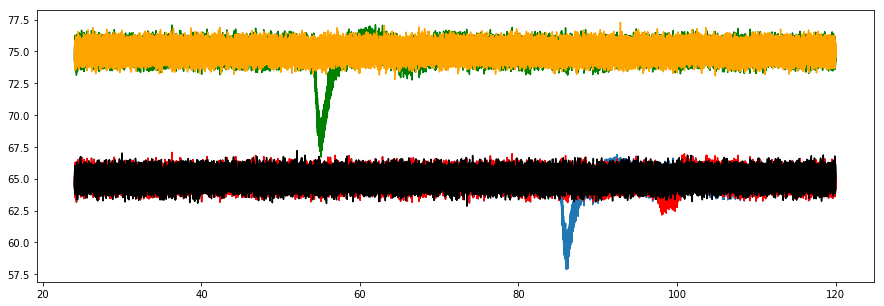

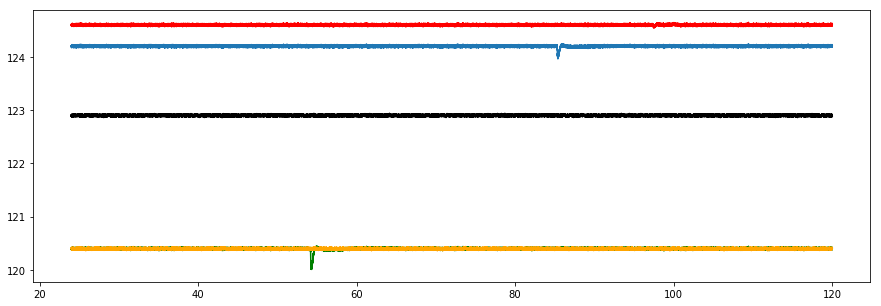

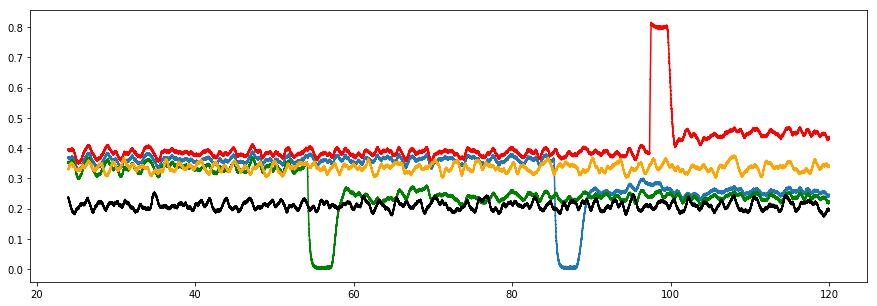

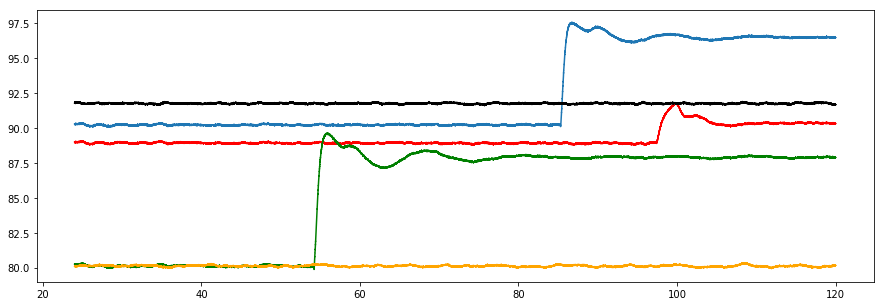

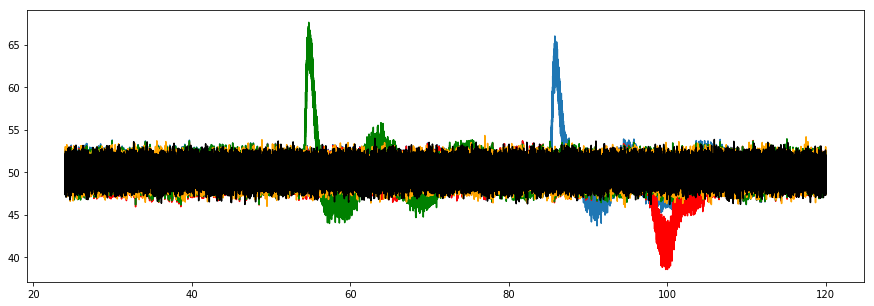

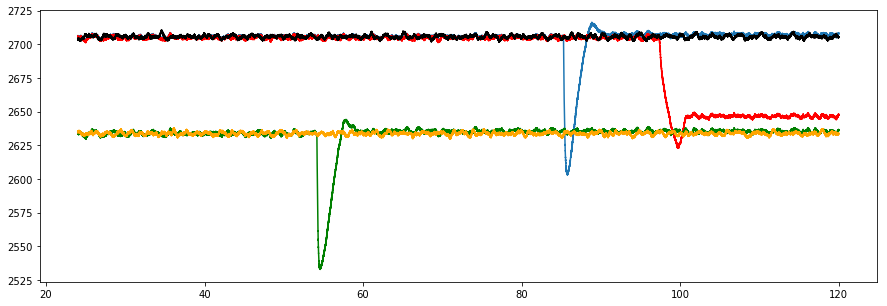

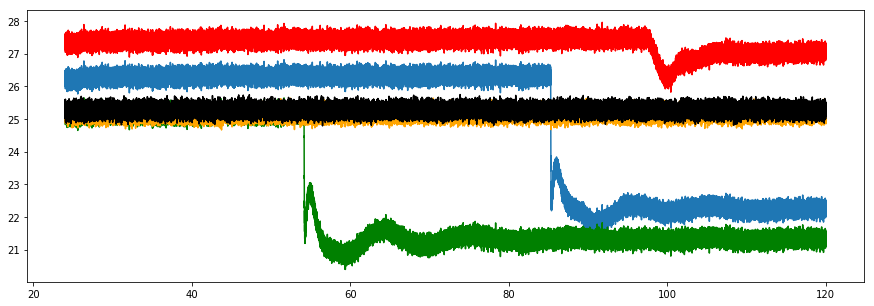

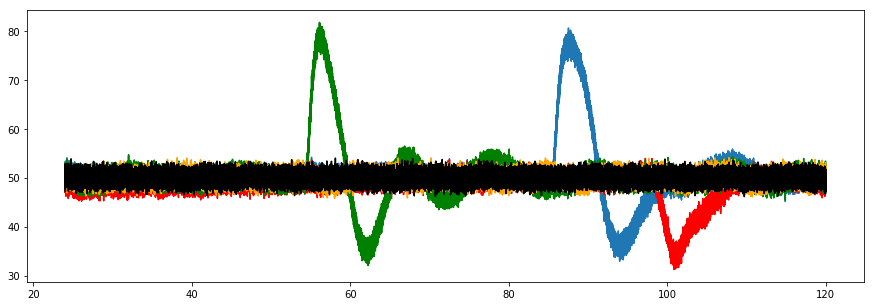

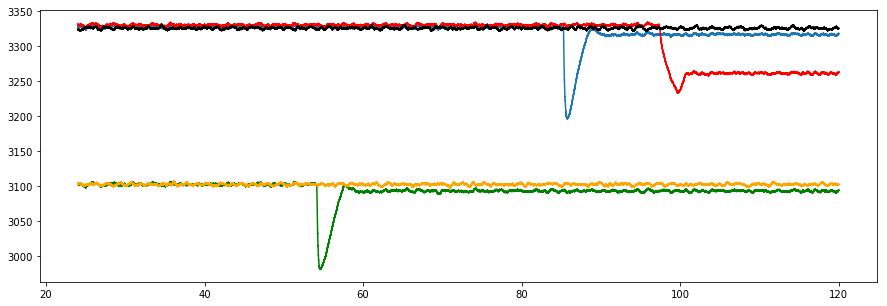

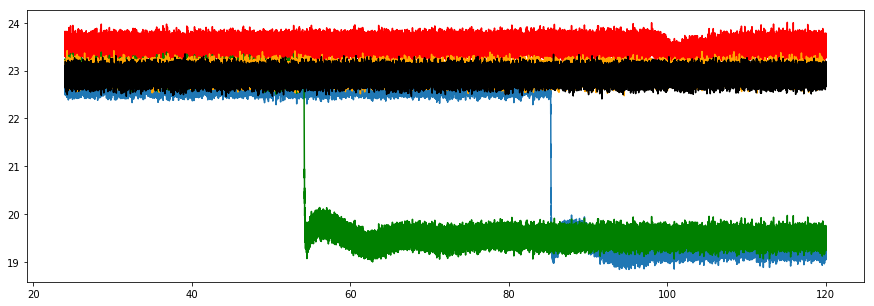

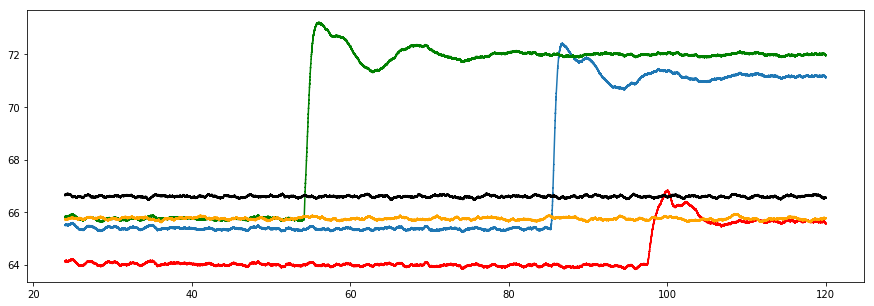

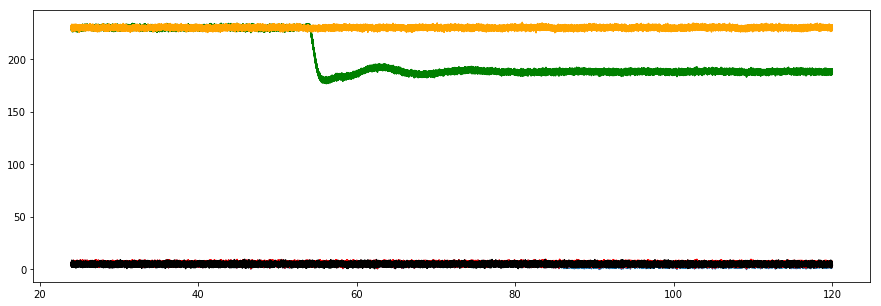

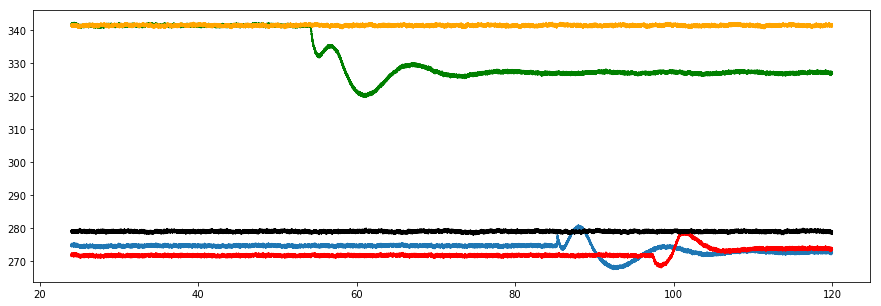

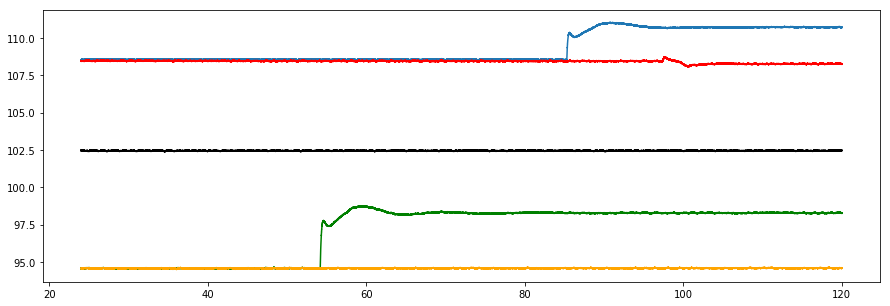

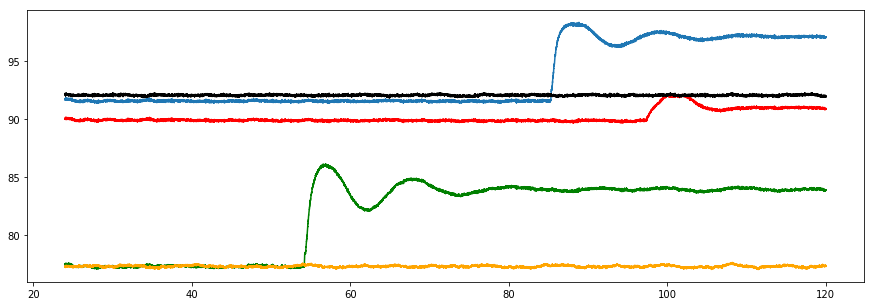

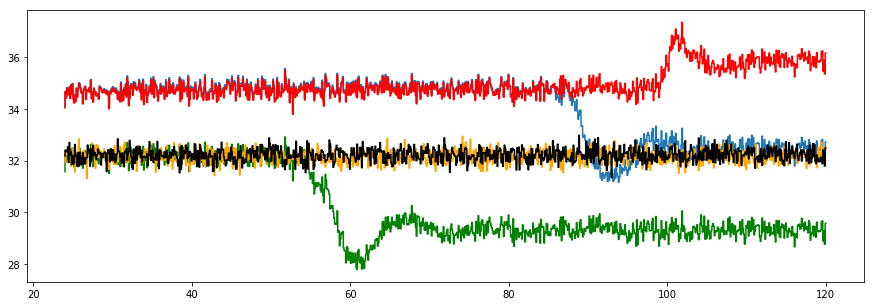

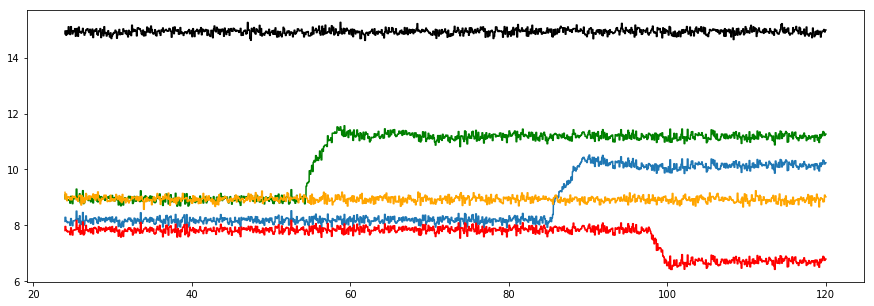

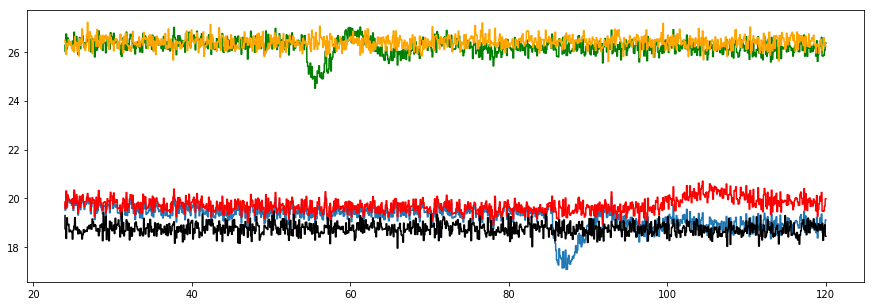

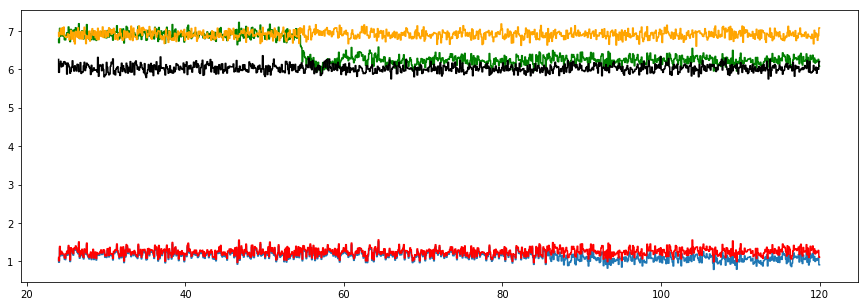

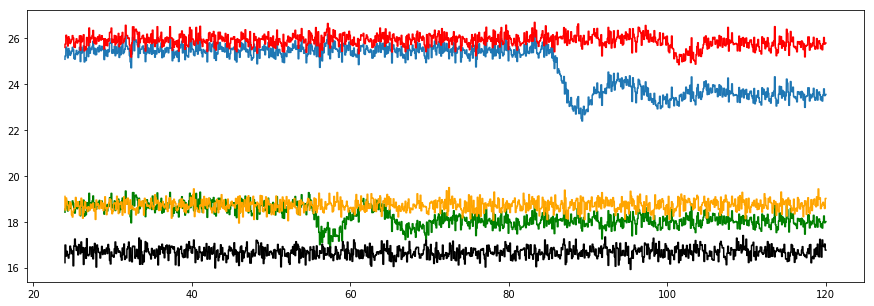

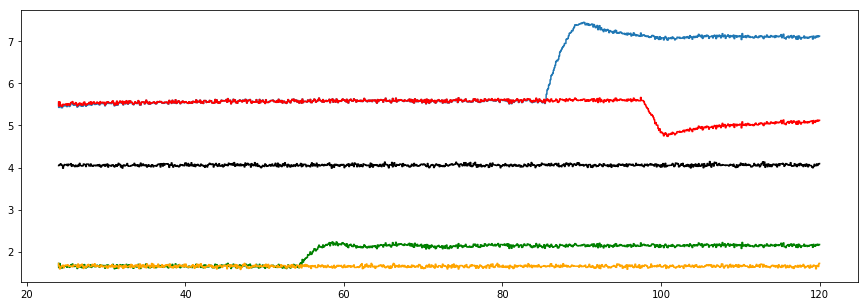

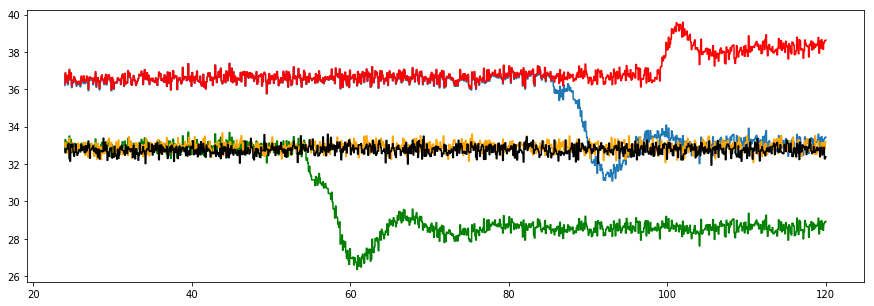

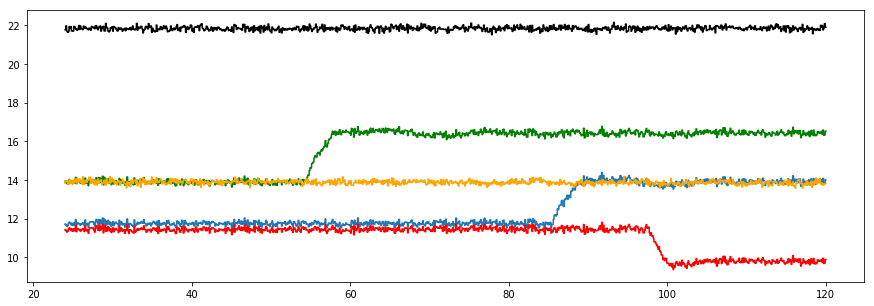

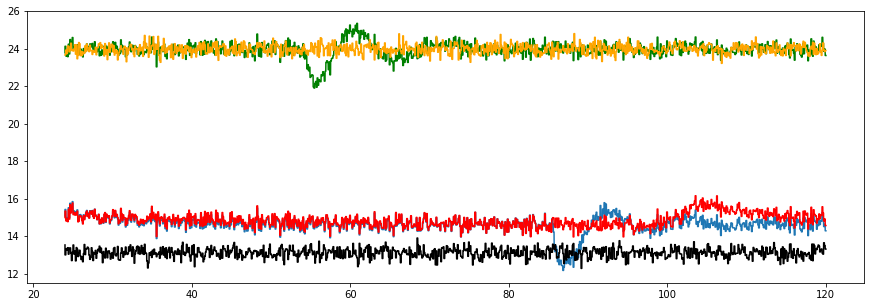

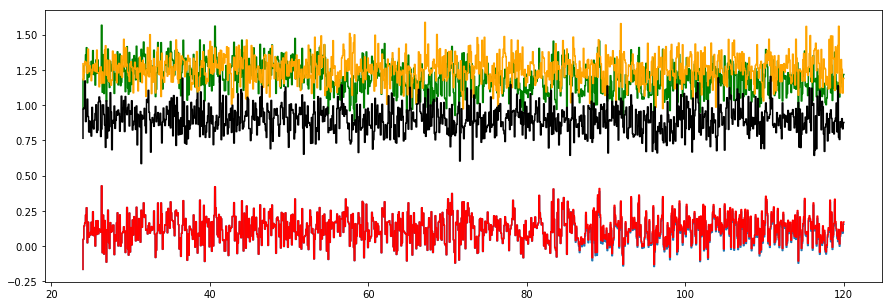

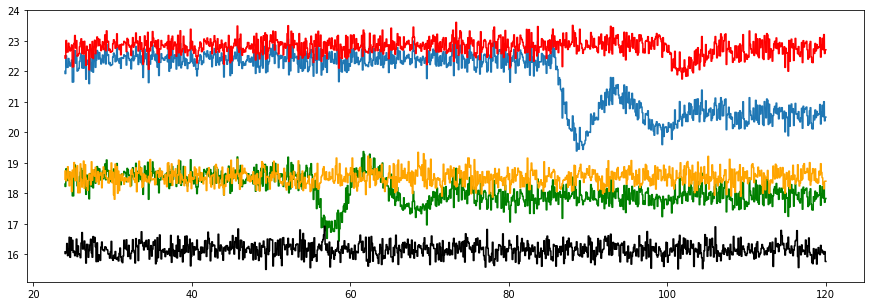

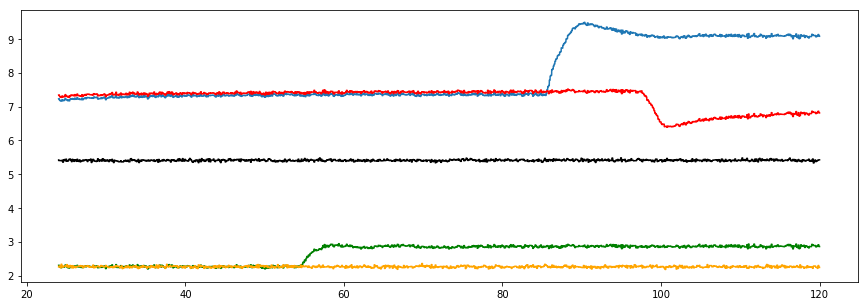

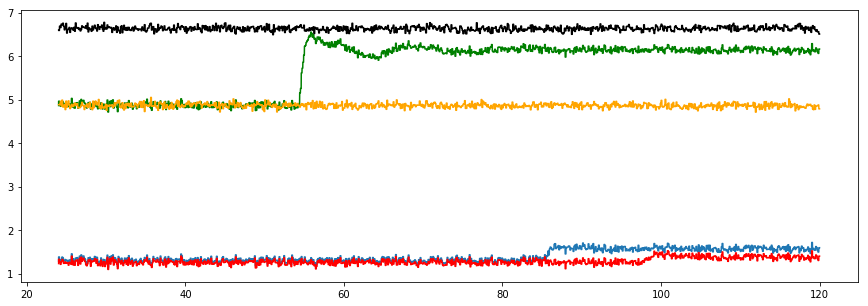

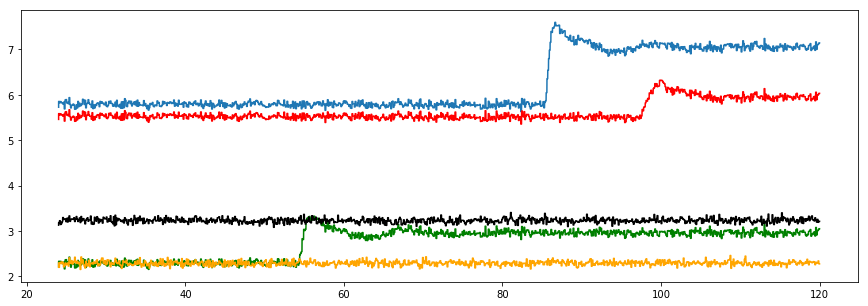

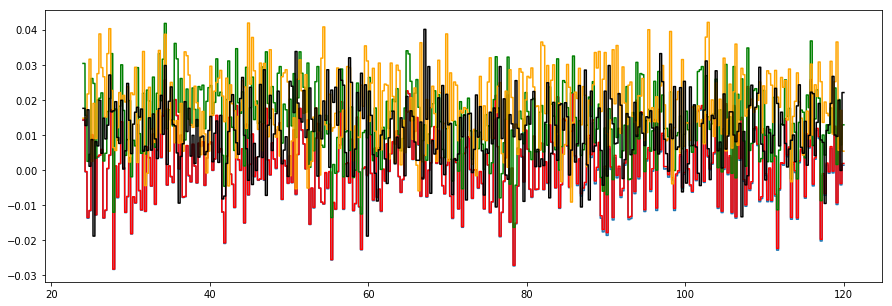

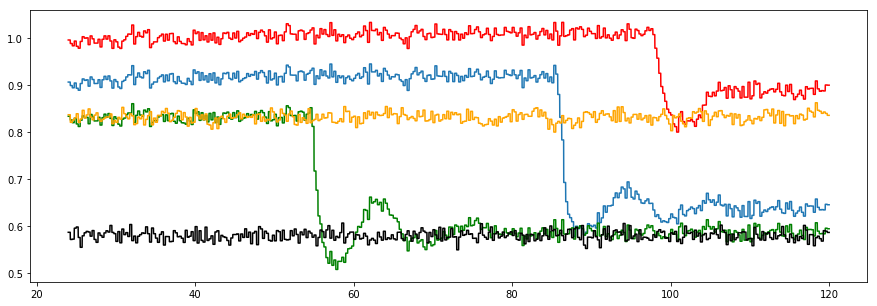

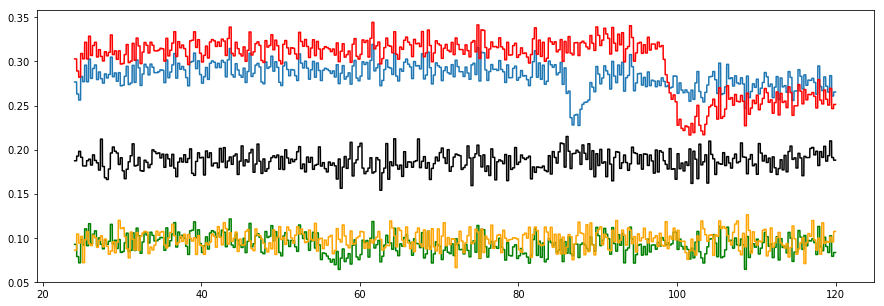

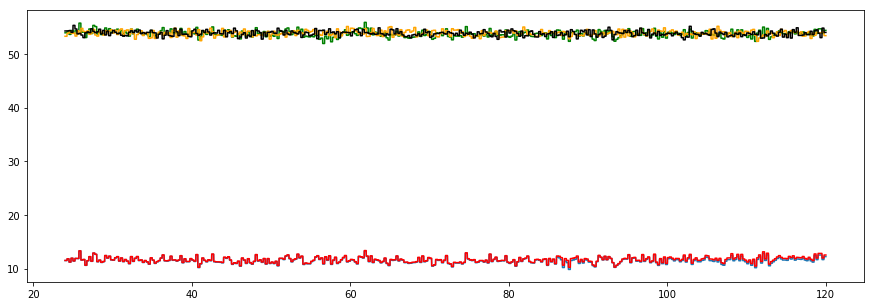

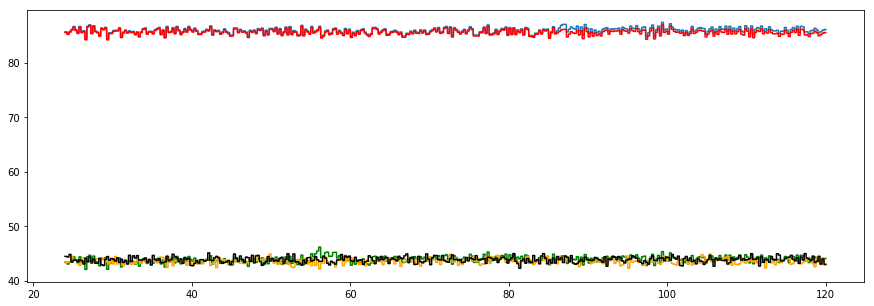

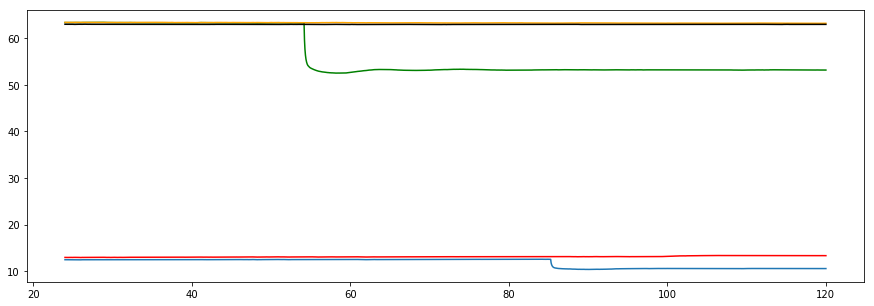

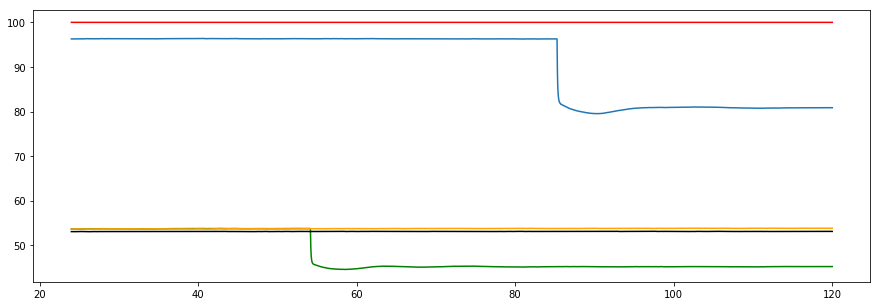

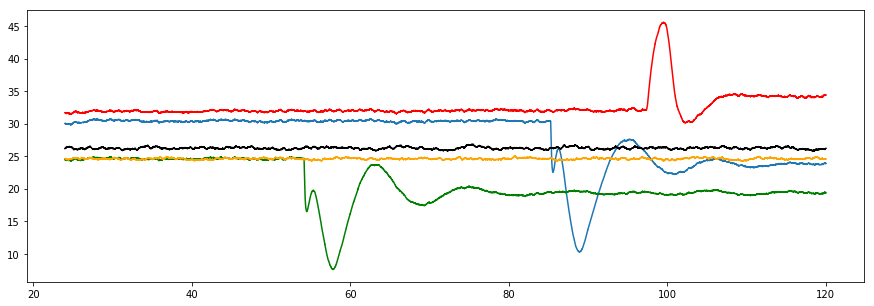

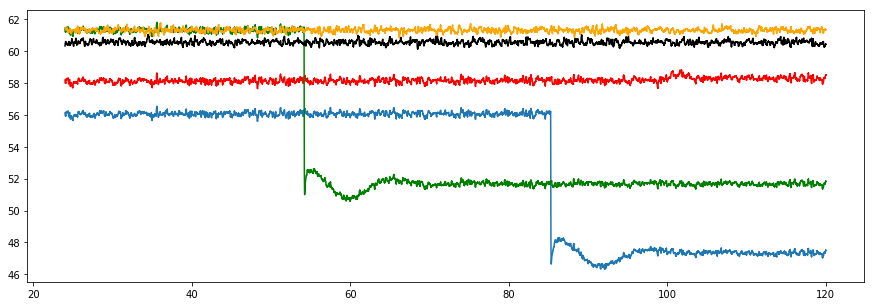

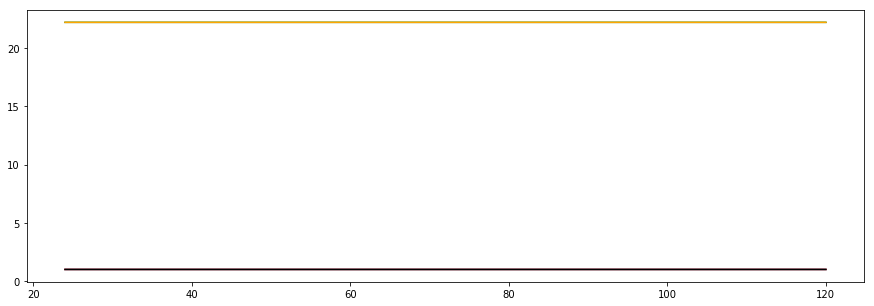

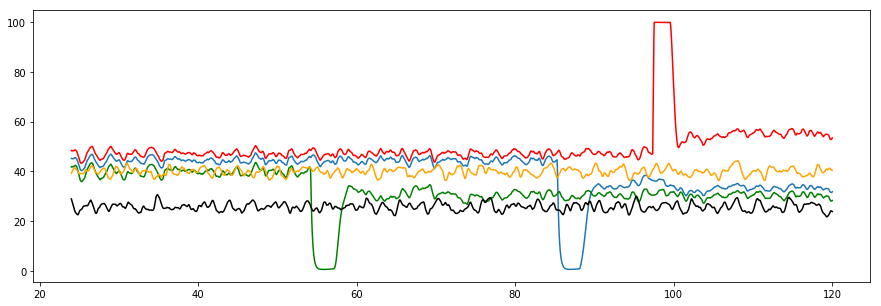

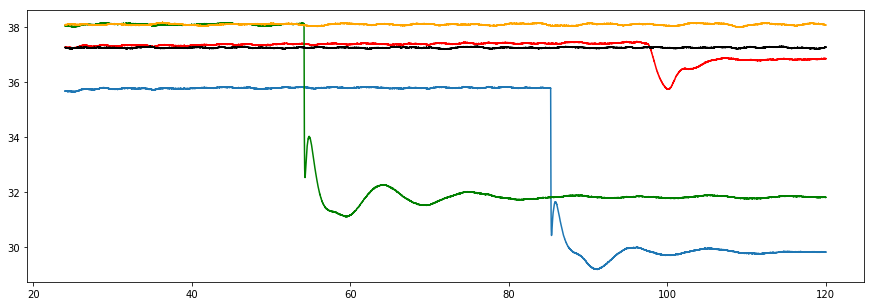

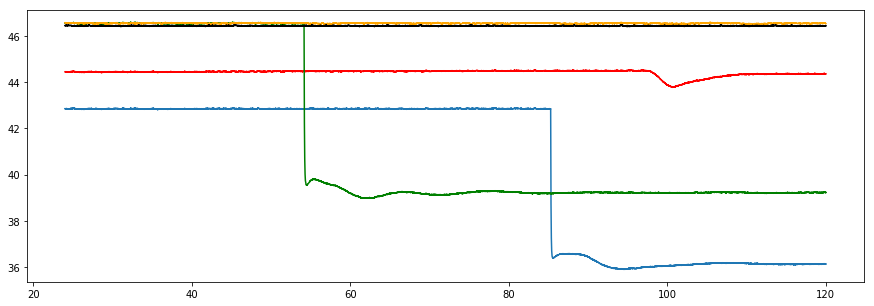

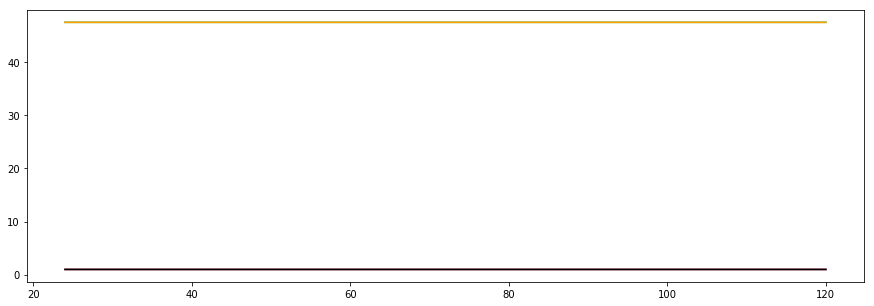

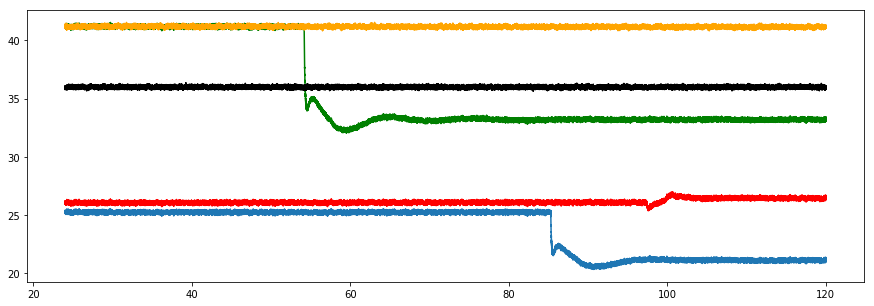

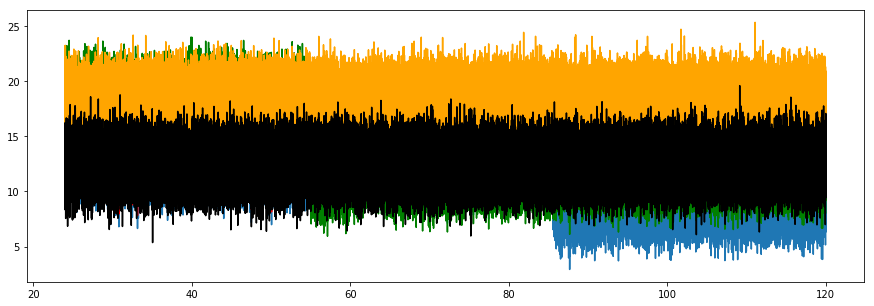

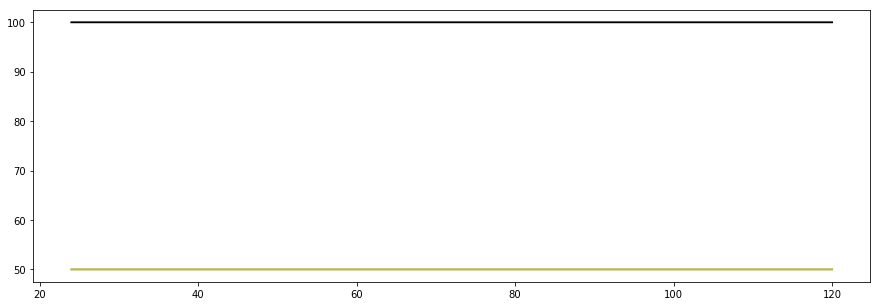

In [123]:
for i in range(54):
    plt.figure(figsize=[15,5])
    plt.plot(xtrain[35,:,0], xtrain[35,:,i])
    plt.plot(xtrain[15,:,0], xtrain[15,:,i], color='r')
    plt.plot(xtrain[25,:,0], xtrain[25,:,i], color='g')
    plt.plot(xtrain[45,:,0], xtrain[45,:,i], color='orange')
    plt.plot(xtrain[95,:,0], xtrain[95,:,i], color='black')
